In [1556]:
import os
import cv2
import random
import shutil
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from scipy.linalg import inv, svd
from sklearn.neighbors import NearestNeighbors
from skfeature.function.similarity_based import fisher_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [1557]:
# Set dataset path (Google Drive or local folder)
d_p = Path("C:\\Users\\prade\\OneDrive\\Desktop\\PROJECT\\Datasets\\LFW_NEW")  # Change this based on your actual folder path
Total_image_per_dataset=20
Num_of_train_image=12
Num_of_test_image=Total_image_per_dataset-Num_of_train_image
Total_class=61

In [1558]:
# === Create Directories if They Do Not Exist ===
P = []  # Training set
t = []  # Test set
shutil.rmtree("C:\\Users\\prade\\OneDrive\\Desktop\\PROJECT\\Datasets\\V1-Y\\P", ignore_errors=True)
shutil.rmtree("C:\\Users\\prade\\OneDrive\\Desktop\\PROJECT\\Datasets\\V1-Y\\t", ignore_errors=True)
train_labels = []
test_labels = []
train_path="C:\\Users\\prade\\OneDrive\\Desktop\\PROJECT\\Datasets\\V1-Y\\P"
test_path="C:\\Users\\prade\\OneDrive\\Desktop\\PROJECT\\Datasets\\V1-Y\\t"
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
IMAGE_SIZE = (32, 32)

# ==== Loop through each subfolder in order ====
subfolders = sorted(os.listdir(d_p))
processed_subfolders = 0
for folder in subfolders:
    person_path = os.path.join(d_p, folder)

    if os.path.isdir(person_path):
        # Filter only valid image files (to avoid hidden/system files)
        images = [f for f in os.listdir(person_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(images) >= Num_of_test_image:  
            test_images = random.sample(images, Num_of_test_image)
            train_images = [img for img in images if img not in test_images]
        else:
            # If fewer than 3 images, use all for training
            test_images = []
            train_images = images

        # ==== Processing Training Set ====
        if train_images:
            os.makedirs(os.path.join(train_path, folder), exist_ok=True)
            for img in train_images:
                img_path = os.path.join(person_path, img)
                #print("train", img_path)
                img_data = cv2.imread(img_path)
                if img_data is not None:
                    img_data = cv2.resize(img_data, IMAGE_SIZE)

                    # Flatten and normalize
                    img_vector = img_data.flatten().astype(np.float32)
                    norm = np.linalg.norm(img_vector, ord=2)
                    if norm != 0:
                        img_vector = img_vector / norm

                    # Append to training set
                    P.append(img_vector)
                    train_labels.append(folder)
                    # Copy image to train directory
                    shutil.copy(img_path, os.path.join(train_path, folder, img))

        # ==== Processing Test Set ====
        if test_images:
            os.makedirs(os.path.join(test_path, folder), exist_ok=True)
            for img in test_images:
                img_path = os.path.join(person_path, img)
                #print("test", img_path)
                img_data = cv2.imread(img_path)
                if img_data is not None:
                    img_data = cv2.resize(img_data, IMAGE_SIZE)

                    # Flatten and normalize
                    img_vector = img_data.flatten().astype(np.float32)
                    norm = np.linalg.norm(img_vector, ord=2)
                    if norm != 0:
                        img_vector = img_vector / norm

                    # Append to test set
                    t.append(img_vector)
                    test_labels.append(folder)
                    os.makedirs(os.path.join(person_path, folder), exist_ok=True)
                    # Copy image to test directory
                    shutil.copy(img_path, os.path.join(test_path, folder, img))

        processed_subfolders += 1

# Convert lists to numpy arrays
P = np.array(P)
t = np.array(t)

# Print shapes
print(f"Training set shape (P): {P.shape}")
print(f"Test set shape (t): {t.shape}")

# Convert labels to numpy arrays if needed
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print(train_labels)
print(test_labels)
print(f"Training labels shape: {train_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Check number of processed subfolders
print(f"Number of processed subfolders: {processed_subfolders}")

Training set shape (P): (732, 3072)
Test set shape (t): (488, 3072)
['Alejandro_Toledo' 'Alejandro_Toledo' 'Alejandro_Toledo'
 'Alejandro_Toledo' 'Alejandro_Toledo' 'Alejandro_Toledo'
 'Alejandro_Toledo' 'Alejandro_Toledo' 'Alejandro_Toledo'
 'Alejandro_Toledo' 'Alejandro_Toledo' 'Alejandro_Toledo' 'Alvaro_Uribe'
 'Alvaro_Uribe' 'Alvaro_Uribe' 'Alvaro_Uribe' 'Alvaro_Uribe'
 'Alvaro_Uribe' 'Alvaro_Uribe' 'Alvaro_Uribe' 'Alvaro_Uribe'
 'Alvaro_Uribe' 'Alvaro_Uribe' 'Alvaro_Uribe' 'Amelie_Mauresmo'
 'Amelie_Mauresmo' 'Amelie_Mauresmo' 'Amelie_Mauresmo' 'Amelie_Mauresmo'
 'Amelie_Mauresmo' 'Amelie_Mauresmo' 'Amelie_Mauresmo' 'Amelie_Mauresmo'
 'Amelie_Mauresmo' 'Amelie_Mauresmo' 'Amelie_Mauresmo' 'Andre_Agassi'
 'Andre_Agassi' 'Andre_Agassi' 'Andre_Agassi' 'Andre_Agassi'
 'Andre_Agassi' 'Andre_Agassi' 'Andre_Agassi' 'Andre_Agassi'
 'Andre_Agassi' 'Andre_Agassi' 'Andre_Agassi' 'Angelina_Jolie'
 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie' 'Angelina_Jolie'
 'Angelina_Jolie' 'Angelina_J

TRAINING SET COMPUTING OF MAIN Q

In [1560]:
P.shape

(732, 3072)

In [1561]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load Pretrained ResNet50 Model (without classification head)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
# Data Augmentation
def extract_features(img_path, model):
    """Extract deep features from an image using ResNet50"""
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize
    features = model.predict(img_array)  # Extract features
    return features.flatten()  # Convert to 1D array
# Load dataset (Change path to your dataset)
dataset_path = "C:\\Users\\prade\\OneDrive\\Desktop\\PROJECT\\Datasets\\V1-Y\\P"
classes = os.listdir(dataset_path)
X, y = [], []

for label, class_name in enumerate(classes):
    img_files = glob(os.path.join(dataset_path, class_name, "*.jpg"))  # Adjust for your format
    for img_path in img_files:
        features = extract_features(img_path, base_model)
        X.append(features)
        y.append(label)


# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [1562]:
P=X
print(P.shape)

(732, 2048)


In [1563]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
from glob import glob

# Load Pretrained ResNet50 Model (without classification head)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path, model):
    """Extract deep features from an image using ResNet50"""
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Normalize
    features = model.predict(img_array)  # Extract features
    return features.flatten()  # Convert to 1D array

# Load dataset (Change path to your dataset)
dataset_path = "C:\\Users\\prade\\OneDrive\\Desktop\\PROJECT\\Datasets\\V1-Y\\t"
classes = os.listdir(dataset_path)
X, y = [], []

for label, class_name in enumerate(classes):
    img_files = glob(os.path.join(dataset_path, class_name, "*.jpg"))  # Adjust for your format
    for img_path in img_files:
        features = extract_features(img_path, base_model)
        X.append(features)
        y.append(label)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [1564]:
t=X
print(t.shape)

(488, 2048)


In [1565]:
#YET TO GENERALIZE
# Initialize a 750x750 matrix with zeros
matrix_size = Num_of_train_image*Total_class
block_size = Num_of_train_image
Y = np.zeros((matrix_size, matrix_size))

# Fill the matrix with the specified pattern
for i in range(0, matrix_size, block_size):
    Y[i:i + block_size, i:i + block_size] = 1

# Display the matrix
print(Y)
print("Y shape:",Y.shape)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
Y shape: (732, 732)


In [1566]:
P.shape

(732, 2048)

FISHER SCORE IN ICSDLSR

In [1568]:
# Fisher Score function for feature selection
#import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skfeature.function.similarity_based import fisher_score

# Assume X has shape (600, 3072) and y has corresponding labels
X = P  # Replace with actual dataset
y = train_labels  # Binary classification labels
# Split data into training and testing sets

# Ensure correct shapes
print("X shape:", X.shape)  # Should be (n_samples, n_features)
print("y shape:", y.shape)  # Should be (n_samples,)

# Apply Fisher Score
score = fisher_score.fisher_score(X, y)
print("Fisher Score Computed Successfully")
selected_features = np.argsort(score)[-1000:]  # Select top 50 features

P1 = X[:, selected_features]
print(P1)


X shape: (732, 2048)
y shape: (732,)
Fisher Score Computed Successfully
[[3.3029857e-01 2.9896580e-02 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.5604547e-01]
 [2.6612332e-01 2.0107567e-01 2.7021205e-01 ... 5.6153950e-03
  5.7913419e-02 1.4477928e-01]
 [1.4602882e+00 1.2604266e-03 1.9153433e-02 ... 7.5178248e-01
  7.7108562e-02 0.0000000e+00]
 ...
 [6.3194460e-01 8.0282763e-02 1.9171870e-03 ... 3.6580643e-01
  1.9938076e-01 7.7420712e-02]
 [6.7334259e-01 5.1060134e-01 0.0000000e+00 ... 6.9889002e-02
  4.2172787e-01 0.0000000e+00]
 [2.7675396e-01 4.2670670e-01 0.0000000e+00 ... 2.9406426e-03
  1.9591644e-02 2.9399147e-02]]


In [1569]:
t1=t[:,selected_features]
print(P.shape)

P1 = P1.T
print(P1.shape)
print(t1.shape)

(732, 2048)
(1000, 732)
(488, 1000)


In [1570]:
class ICS_DLSR:
    def __init__(self, P1, Y, lambda1, lambda2, lambda3, rho=1.01, mu_init=1e-8, mu_max=1e8):
        self.P1 = P1  # Data matrix (m x n)
        self.Y = Y  # Label matrix (c x n)

        # Dimensions
        m, n = P1.shape
        c = Y.shape[0]

        self.m = m
        self.n = n
        self.c = c

        # Regularization parameters
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3

        # Penalty parameters
        self.rho = rho
        self.mu = mu_init
        self.mu_max = mu_max

        # Initialization
        self.Q = np.random.randn(self.c, self.m)  # Regression matrix (c x m)
        self.F = self.Q @ self.P1  # Auxiliary variable (c x n)
        self.C = np.zeros((self.c, self.n))  # Lagrange multiplier (c x n)
        self.E = np.zeros((self.c, self.n))  # Error matrix (c x n)

    def update_Q(self):
        G1 = self.Y + self.E
        G2 = self.F + (self.C / self.mu)

        A = (1 + self.mu) * (self.P1 @ self.P1.T) + self.lambda1 * np.eye(self.m)
        B = (G1 + self.mu * G2) @ self.P1.T

        self.Q = B @ np.linalg.inv(A)

    def update_F(self):
        H = self.Q @ self.P1 - (self.C / self.mu)
        self.F = np.zeros_like(H)

        for j in range(H.shape[0]):
            norm_Hj = np.linalg.norm(H[j, :], 2)
            if norm_Hj > (self.lambda2 / self.mu):
                self.F[j, :] = ((norm_Hj - (self.lambda2 / self.mu)) / norm_Hj) * H[j, :]
            else:
                self.F[j, :] = 0

    def update_E(self):
        U = self.Q @ self.P1 - self.Y
        self.E = np.zeros_like(U)

        for j in range(U.shape[0]):
            norm_Uj = np.linalg.norm(U[j, :], 2)
            if norm_Uj > self.lambda3:
                self.E[j, :] = ((norm_Uj - self.lambda3) / norm_Uj) * U[j, :]
            else:
                self.E[j, :] = 0

    def update_C_mu(self):
        self.C += self.mu * (self.F - self.Q @ self.P1)
        self.mu = min(self.rho * self.mu, self.mu_max)

    def compute_objective(self):
        term1 = 0.5 * np.linalg.norm(self.Y + self.E - self.Q @ self.P1, 'fro')**2
        term2 = (self.lambda1 / 2) * np.linalg.norm(self.Q, 'fro')**2
        term3 = self.lambda2 * np.sum([np.linalg.norm(self.F[i, :], 2) for i in range(self.c)])
        term4 = self.lambda3 * np.sum([np.linalg.norm(self.E[i, :], 2) for i in range(self.c)])
        term5 = (self.mu / 2) * np.linalg.norm(self.F - self.Q @ self.P1 + (self.C / self.mu), 'fro')**2
        return term1 + term2 + term3 + term4 + term5

    def fit(self, tol=1e-6, max_iter=500):
        for iteration in range(max_iter):
            Q_prev = self.Q.copy()

            # Update Q, F, E, and (C, µ)
            self.update_Q()
            self.update_F()
            self.update_E()
            self.update_C_mu()

            # Check convergence (if Q stops changing significantly)
            diff = np.linalg.norm(self.Q - Q_prev, 'fro')
            if diff < tol:
                print(f"Convergence reached at iteration {iteration + 1}.")
                break

    def get_results(self):
        return self.Q, self.E
    
# Regularization parameters
lambda1 = 0.01
lambda2 = 0.01
lambda3 = 0.01

# Create and fit the ICS_DLSR model
model = ICS_DLSR(P1, Y, lambda1, lambda2, lambda3)
model.fit()

# Retrieve the optimized matrices
Q1, E_opt = model.get_results()

print("Optimized Q:\n", Q1)
print(Q1.shape)
print("Optimized E:\n", E_opt)
print(E_opt.shape)
objective_value = model.compute_objective()
print("Computed Objective Value:", objective_value)

Optimized Q:
 [[-0.02689298  0.0439878  -0.07197626 ... -0.00209442 -0.03777207
  -0.04150324]
 [-0.02689298  0.0439878  -0.07197626 ... -0.00209442 -0.03777207
  -0.04150324]
 [-0.02689298  0.0439878  -0.07197626 ... -0.00209442 -0.03777207
  -0.04150324]
 ...
 [-0.05966704 -0.00865369  0.02684095 ...  0.05370834  0.03005737
  -0.040618  ]
 [-0.05966704 -0.00865369  0.02684095 ...  0.05370834  0.03005737
  -0.040618  ]
 [-0.05966704 -0.00865369  0.02684095 ...  0.05370834  0.03005737
  -0.040618  ]]
(732, 1000)
Optimized E:
 [[-0.07038824 -0.00569079 -0.03893827 ...  0.00431043  0.00124029
   0.00608899]
 [-0.07038824 -0.00569079 -0.03893827 ...  0.00431043  0.00124029
   0.00608899]
 [-0.07038824 -0.00569079 -0.03893827 ...  0.00431043  0.00124029
   0.00608899]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [1571]:
# Define image size (resize all images to this size)
IMAGE_SIZE = (32,32)  # You can change this

# Get list of subfolders (each subfolder is a dog breed)
face = sorted([folder.name for folder in d_p.iterdir() if folder.is_dir()])
print("Face Found:", face)

# Initialize empty lists to store data

Z = []
# Loop through each breed (subfolder)
for f in face:
    f_path = d_p / f

    for img_file in f_path.glob("*.jpg"):  # Adjust file extensions if needed
        # Read and resize image
        img = cv2.imread(str(img_file))  # Read image
        img = cv2.resize(img, IMAGE_SIZE)  # Resize to fixed size
        img = img / 255.0  # Normalize pixel values (0 to 1)
        # Append corresponding label
        Z.append(f)
# Convert lists to NumPy arrays

print(P.shape)
Z = np.array(Z)
Z.shape
# Encode labels as numbers
label_encoder = LabelEncoder()
Z_encoded = label_encoder.fit_transform(Z)  # Converts breed names to integer labels
print(f"Target Matrix Z Shape: {Z_encoded.shape}")  # (n,)
print(f"Unique Labels: {len(np.unique(Z_encoded))}")

Face Found: ['Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo', 'Andre_Agassi', 'Angelina_Jolie', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld', 'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria', 'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Igor_Ivanov', 'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez', 'Jeremy_Greenstock', 'Jiang_Zemin', 'John_Ashcroft', 'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero', 'Kofi_Annan', 'Laura_Bush', 'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva', 'Mahmoud_Abbas', 'Megawati_Sukarnoputri', 'Michael_Bloomberg', 'Naomi_Watts', 'Nestor_Kirchner', 'Paul_Bremer', 'Pete_Sampras', 'Recep_Tayyip_Erdogan', 'Ricardo_Lagos', 'Roh_Moo-hyun', 'Rudolph_Giuliani', 'Saddam_Hussein', 'Serena_Williams', 'Silvio_Ber

RELIFE IN ICS_CDLSR

In [1573]:
#relief_scores = reliefF(P,Z_encoded)
#ranked_features = np.argsort(relief_scores)[::-1]
score = fisher_score.fisher_score(P,train_labels)
print(score)
selected_features = np.argsort(score)[-1000:]  # Select top 50 features

P2 = P[:, selected_features]
print(P2)
# Selecting top 1000 features
#top = ranked_features[:1000]
#P2 = P[:, top]

print("P2 shape after selecting top 1000 features:", P2.shape)
print(P2)

[1918  494 2040 ...  428 1113  730]
[[3.3029857e-01 2.9896580e-02 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.5604547e-01]
 [2.6612332e-01 2.0107567e-01 2.7021205e-01 ... 5.6153950e-03
  5.7913419e-02 1.4477928e-01]
 [1.4602882e+00 1.2604266e-03 1.9153433e-02 ... 7.5178248e-01
  7.7108562e-02 0.0000000e+00]
 ...
 [6.3194460e-01 8.0282763e-02 1.9171870e-03 ... 3.6580643e-01
  1.9938076e-01 7.7420712e-02]
 [6.7334259e-01 5.1060134e-01 0.0000000e+00 ... 6.9889002e-02
  4.2172787e-01 0.0000000e+00]
 [2.7675396e-01 4.2670670e-01 0.0000000e+00 ... 2.9406426e-03
  1.9591644e-02 2.9399147e-02]]
P2 shape after selecting top 1000 features: (732, 1000)
[[3.3029857e-01 2.9896580e-02 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.5604547e-01]
 [2.6612332e-01 2.0107567e-01 2.7021205e-01 ... 5.6153950e-03
  5.7913419e-02 1.4477928e-01]
 [1.4602882e+00 1.2604266e-03 1.9153433e-02 ... 7.5178248e-01
  7.7108562e-02 0.0000000e+00]
 ...
 [6.3194460e-01 8.0282763e-02 1.9171870e-03 ... 3.6580643e-0

In [1574]:
print(P2.shape)
print(P2)
t2=t[:,selected_features]
P2 = P2.T
print(P2.shape)

(732, 1000)
[[3.3029857e-01 2.9896580e-02 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.5604547e-01]
 [2.6612332e-01 2.0107567e-01 2.7021205e-01 ... 5.6153950e-03
  5.7913419e-02 1.4477928e-01]
 [1.4602882e+00 1.2604266e-03 1.9153433e-02 ... 7.5178248e-01
  7.7108562e-02 0.0000000e+00]
 ...
 [6.3194460e-01 8.0282763e-02 1.9171870e-03 ... 3.6580643e-01
  1.9938076e-01 7.7420712e-02]
 [6.7334259e-01 5.1060134e-01 0.0000000e+00 ... 6.9889002e-02
  4.2172787e-01 0.0000000e+00]
 [2.7675396e-01 4.2670670e-01 0.0000000e+00 ... 2.9406426e-03
  1.9591644e-02 2.9399147e-02]]
(1000, 732)


In [1575]:
import numpy as np
from numpy.linalg import inv
from sklearn.preprocessing import OneHotEncoder

def initialize_variables(X, Y, c):
    d, n = X.shape  # d: features, n: samples
    encoder = OneHotEncoder(sparse_output=False, categories='auto')
    H = encoder.fit_transform(Y.reshape(-1, 1)).T  # One-hot encoding (c x n)
    #print(np.array2string(H, threshold=np.inf))
    ones_matrix = np.ones(H.shape)  # Shape: (c, n)
    B = 2 * H - ones_matrix  # Relaxation matrix (c x n)
    W = np.zeros((c, d))  # Projection matrix (c x d)

    # Change the shape of S to match the second dimension of B (n)
    S = np.zeros((c, n))  # Shape: (c, n)  # Updated to match B's shape
    print("H",H.shape)
    print("B",B.shape)
    print("S",S.shape)
    T = H + (B * S)  # Target matrix (c x n)
    E = np.zeros((c, n))  # Error matrix (c x n)
    R1 = np.zeros((c, n))  # Lagrange multiplier matrix (c x n)
    return W, S, T, E, R1, H, B

def fisher_criterion(T):
    c, n = T.shape  # Number of classes (rows) and samples per class (columns)
    M = np.mean(T, keepdims=True)  # Global mean as a scalar
    fisher_term = 0

    for i in range(c):
        Ti = T[i, :].reshape(1, -1)  # Ensure Ti is a 2D row vector
        Mi = np.mean(Ti, keepdims=True)  # Class mean as a scalar
        fisher_term += np.linalg.norm(Ti - Mi, 'fro')**2 - np.linalg.norm(Mi - M, 'fro')**2

    return fisher_term + np.linalg.norm(T, 'fro')**2

def update_T(W, X, H, B, S, E, R1, alpha, lambda_, mu):
    WX = W @ X
    M = np.mean(WX, axis=1, keepdims=True)
    M_hat = np.mean(WX, axis=1, keepdims=True)
    T = ((W @ X + alpha * (H + (B * S)) - lambda_ * (M - (2 * M_hat)) + (mu / 2) * (WX - E) + (R1 / 2))) / (1 + alpha +( 2 * lambda_ )+ (mu / 2))
    return T

def update_W(T, X, E, R1, beta, mu):
    XT = X.T
    W = (T + ((mu / 2) * (T + E)) + (R1 / 2)) @ XT @ inv(((mu / 2) + 1) * (X @ XT) + beta * np.eye(X.shape[0]))
    return W

def update_S(T, H, B):
    S = np.maximum(B * (T - H), 0)
    return S

def compute_E(gamma, Lambda_prime, mu, I, Q):
    term = inv(2 * gamma * Lambda_prime + (mu * I))
    E = term @ (mu * Q)
    return E

def compute_Lambda_prime(E, Delta):
    d, c = E.shape
    Lambda_prime = np.zeros((d, d))
    for i in range(d):
        sum_eij_squared = np.sum(E[i, :] ** 2)
        Lambda_prime[i, i] = 1 / (2 * np.sqrt(sum_eij_squared + Delta))
    return Lambda_prime

def update_E(W, X, T, R1, gamma, mu, Delta=1e-5):
    Q = W @ X - T + R1 / mu
    I = np.eye(Q.shape[0])
    Lambda_prime = compute_Lambda_prime(Q, Delta)
    E = compute_E(gamma, Lambda_prime, mu, I, Q)
    return E

def dcdlsr(X, Y, alpha=1, beta=0.01, lambda_=1, gamma=1, mu=1e-5, max_iter=500):
    c = np.unique(Y).size  # Number of classes
    W, S, T, E, R1, H, B = initialize_variables(X, Y, c)
    for _ in range(max_iter):
        T = update_T(W, X, H, B, S, E, R1, alpha, lambda_, mu)
        W = update_W(T, X, E, R1, beta, mu)
        S = update_S(T, H, B)
        E = update_E(W, X, T, R1, gamma, mu)
        R1 = R1 + (mu * (E - ((W @ X )- T)))
        mu = min(10, 1.1 * mu)
    return W, E

# Train DCDLSR model
W, e = dcdlsr(P2,train_labels )
Q2=W
print(W)
print(e)
print(W.shape)


H (61, 732)
B (61, 732)
S (61, 732)
[[-0.01607632  0.01123996 -0.03150637 ... -0.00015668 -0.01587886
  -0.01508974]
 [ 0.00680368  0.01240601  0.0011003  ...  0.02483042 -0.0073841
  -0.01427267]
 [ 0.0025954   0.00095908 -0.01084412 ...  0.01101486  0.01124045
   0.00921841]
 ...
 [-0.00153593 -0.01875707  0.00708815 ...  0.00531385  0.01395181
  -0.02197497]
 [-0.02055963 -0.01279537  0.01253875 ... -0.01731698  0.01731197
   0.00638407]
 [-0.02411738 -0.0046508   0.01054813 ...  0.01811989  0.00822738
  -0.01338356]]
[[ 8.71589838e-06  2.28870929e-07  4.77598329e-06 ... -6.70370486e-07
  -4.95498633e-07 -9.34787085e-07]
 [ 3.67196805e-06  2.27820902e-07 -4.87773141e-07 ... -1.29690875e-07
  -3.53028329e-07 -6.35235258e-07]
 [-2.12103150e-06 -3.34910074e-07 -1.24183329e-06 ...  3.54938449e-07
  -1.28353420e-06  1.36933313e-06]
 ...
 [-1.17849930e-06  4.90212284e-07 -3.68423620e-07 ... -2.63327561e-07
  -1.07863066e-06 -5.84695367e-07]
 [ 9.35735662e-07  1.18255614e-06 -1.19920416e-0

Q1 and Q2 CONCATINATION

In [1577]:
Qsum = np.vstack((Q1, Q2)) # Concatenate along columns
print("Concatenated Optimum Matrix Shape:", Qsum.shape)
print(Qsum)

Concatenated Optimum Matrix Shape: (793, 1000)
[[-0.02689298  0.0439878  -0.07197626 ... -0.00209442 -0.03777207
  -0.04150324]
 [-0.02689298  0.0439878  -0.07197626 ... -0.00209442 -0.03777207
  -0.04150324]
 [-0.02689298  0.0439878  -0.07197626 ... -0.00209442 -0.03777207
  -0.04150324]
 ...
 [-0.00153593 -0.01875707  0.00708815 ...  0.00531385  0.01395181
  -0.02197497]
 [-0.02055963 -0.01279537  0.01253875 ... -0.01731698  0.01731197
   0.00638407]
 [-0.02411738 -0.0046508   0.01054813 ...  0.01811989  0.00822738
  -0.01338356]]


In [1578]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer(norm='l2') 
Q_opt = scaler.fit_transform(Qsum)
print(Q_opt.shape)
print(Q_opt)

(793, 1000)
[[-0.02358359  0.03857475 -0.06311901 ... -0.00183668 -0.03312391
  -0.03639594]
 [-0.02358359  0.03857475 -0.06311901 ... -0.00183668 -0.03312391
  -0.03639594]
 [-0.02358359  0.03857475 -0.06311901 ... -0.00183668 -0.03312391
  -0.03639594]
 ...
 [-0.0033888  -0.04138473  0.01563896 ...  0.01172423  0.03078263
  -0.04848455]
 [-0.04038939 -0.02513649  0.02463237 ... -0.0340192   0.03400937
   0.01254151]
 [-0.07146694 -0.01378169  0.03125724 ...  0.05369462  0.02438018
  -0.03965946]]


In [1579]:
Psum = sum((P1, P2)) # Concatenate along columns
print("Concatenated Optimum Matrix Shape:", Psum.shape)
print(Psum)

tsum = sum((t1, t2)) # Concatenate along columns
print("Concatenated Optimum Matrix Shape:", Psum.shape)
print(tsum)

Concatenated Optimum Matrix Shape: (1000, 732)
[[6.6059715e-01 5.3224665e-01 2.9205763e+00 ... 1.2638892e+00
  1.3466852e+00 5.5350792e-01]
 [5.9793159e-02 4.0215135e-01 2.5208532e-03 ... 1.6056553e-01
  1.0212027e+00 8.5341340e-01]
 [0.0000000e+00 5.4042411e-01 3.8306866e-02 ... 3.8343740e-03
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 1.1230790e-02 1.5035650e+00 ... 7.3161286e-01
  1.3977800e-01 5.8812853e-03]
 [0.0000000e+00 1.1582684e-01 1.5421712e-01 ... 3.9876151e-01
  8.4345573e-01 3.9183289e-02]
 [1.1120909e+00 2.8955856e-01 0.0000000e+00 ... 1.5484142e-01
  0.0000000e+00 5.8798295e-02]]
Concatenated Optimum Matrix Shape: (1000, 732)
[[3.27594924e+00 2.04669312e-01 1.05284381e+00 ... 1.61504492e-01
  2.57650744e-02 1.11167773e-03]
 [2.43079233e+00 5.67766070e-01 5.89395583e-01 ... 1.76337436e-01
  0.00000000e+00 0.00000000e+00]
 [1.75845474e-01 1.15551285e-01 1.90624923e-01 ... 5.20632088e-01
  0.00000000e+00 2.57956952e-01]
 ...
 [1.34968385e-01 9.91343707e-02 0.000000

Testing set

In [1581]:
P_cap = Qsum @ Psum
t_cap = Qsum @ tsum.T
print(P_cap.shape)
print(t_cap.shape)

(793, 732)
(793, 488)


Classification

In [1583]:
from collections import Counter

k =  3
y_true = []
y_pred = []
# Initialize accuracy tracking
correct_predictions = 0
total_predictions = 0

# Loop through each test sample
for i in range(t_cap.shape[1]):  # 150 test samples
    test_image = t_cap[:, i]  # Get the ith test image

    # === Step 1: Compute Euclidean Distance ===
    distances = np.linalg.norm(P_cap - test_image[:, np.newaxis], axis=0)  # (600,)
    #print(distances)
    # === Step 2: Find k Nearest Neighbors ===
    nearest_indices = np.argsort(distances)[:k]  # Get indices of k nearest neighbors
    nearest_classes = train_labels[nearest_indices]  # Get the corresponding classes

    # === Step 3: Majority Voting ===
    predicted_class = Counter(nearest_classes).most_common(1)[0][0]
    expected_class = test_labels[i]
    y_true.append(expected_class)
    y_pred.append(predicted_class)
    # === Step 5: Accuracy Calculation ===
    if predicted_class == expected_class:
        correct_predictions += 1
    total_predictions += 1

# === Step 6: Overall Accuracy ===
accuracy = (correct_predictions / total_predictions) * 100
print(f"Overall Accuracy: {accuracy:.2f}%")
print("no. of training: ",Num_of_train_image)

Overall Accuracy: 27.25%
no. of training:  12


In [1584]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Example true labels and predicted labels


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["Class 0", "Class 1"]  # Modify for multi-class problems
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(y_true, y_pred, average='weighted')
print("Precision:", precision)

# Compute recall
recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# Compute F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)
# Plot confusion matrix



Confusion Matrix:
 [[0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 4]]
Accuracy: 0.2725409836065574
Precision: 0.31124777263880443
Recall: 0.2725409836065574
F1 Score: 0.2731612062201092


C:\Users\prade\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


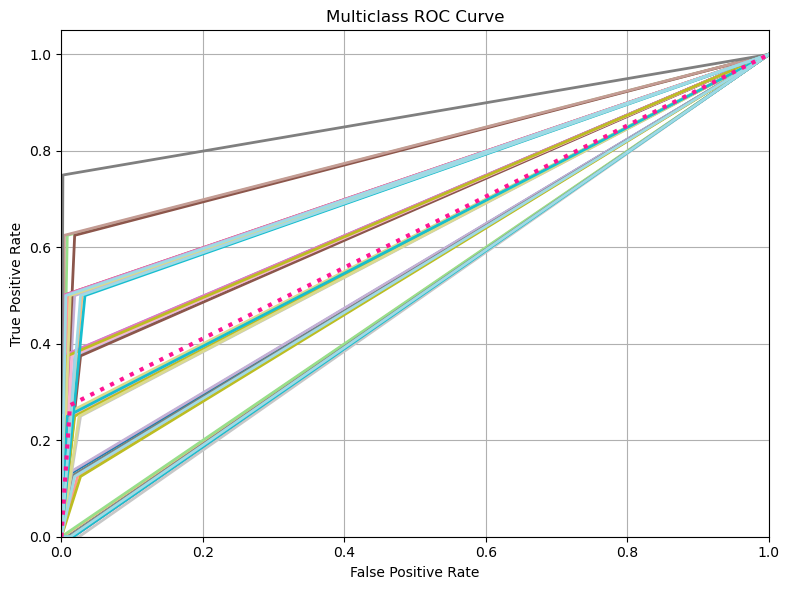

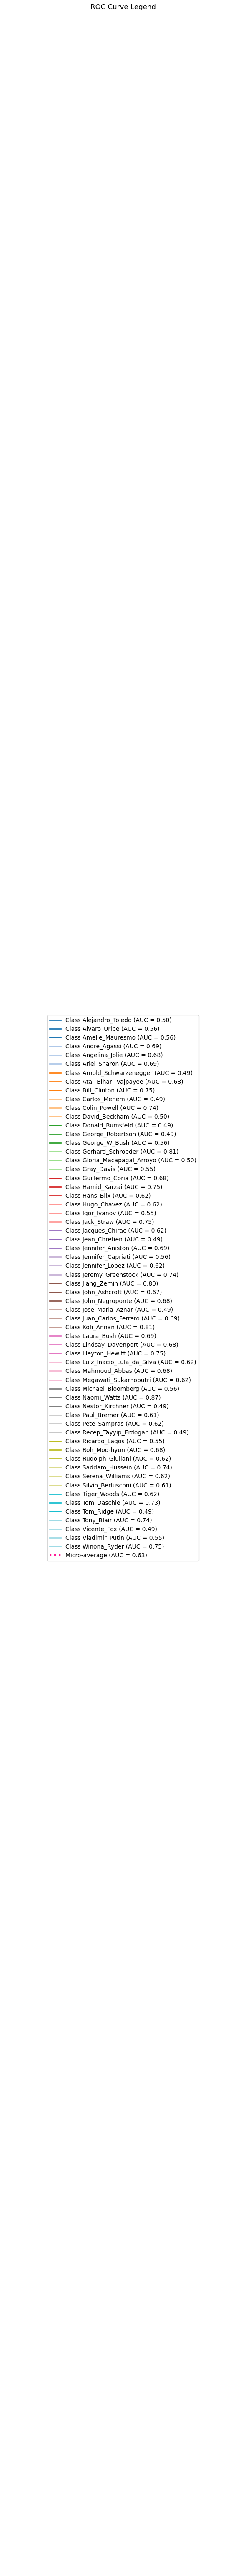

In [1585]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assume y_true, y_pred, and classes are defined
classes = np.unique(y_true)
n_classes = len(classes)

# Binarize the true and predicted labels
y_true_bin = label_binarize(y_true, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)

# Compute ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# === ROC Curve Plot With Different Colors ===
plt.figure(figsize=(8, 6))

# Define colors
colors = plt.cm.tab20(np.linspace(0, 1, n_classes))  # you can change 'tab20' to other colormaps like 'tab10', 'Set3', etc.

# Store lines for legend separately
legend_lines = []
legend_labels = []

# Plot each class with a unique color
for i, color in zip(range(n_classes), colors):
    line, = plt.plot(fpr[i], tpr[i], color=color, lw=2)
    legend_lines.append(line)
    legend_labels.append(f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average in a fixed distinct style
line_micro, = plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3)
legend_lines.append(line_micro)
legend_labels.append(f"Micro-average (AUC = {roc_auc['micro']:.2f})")

# Optional diagonal line
#plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Separate Legend Plot ===
fig_legend = plt.figure(figsize=(6, len(legend_labels)))
fig_legend.legend(legend_lines, legend_labels, loc='center')
plt.axis('off')
plt.title("ROC Curve Legend")
plt.tight_layout()
plt.show()